In [12]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [13]:
# select the device for computation

device = torch.device("cpu")
print(f"using device: {device}")

using device: cpu


In [14]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [15]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

./videos/18/t2


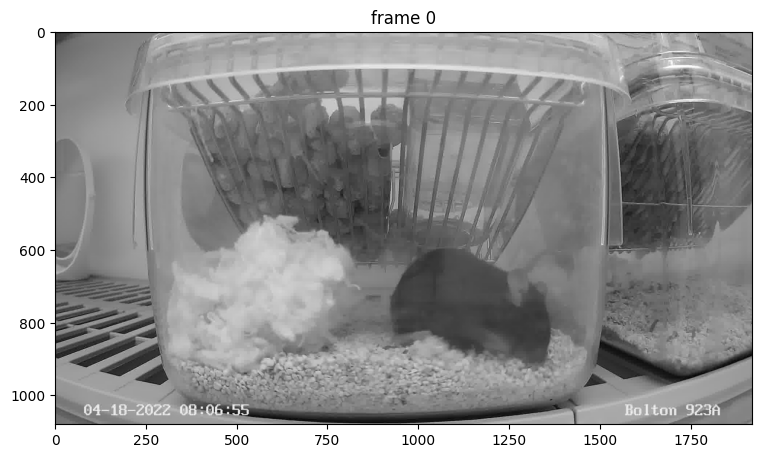

In [ ]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/18/chunk_0"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

print(video_dir)

In [17]:
prompts = {} 

In [18]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 3/3 [00:00<00:00, 45.52it/s]


In [19]:
predictor.reset_state(inference_state)


Found 10801 frames in ./videos/18.


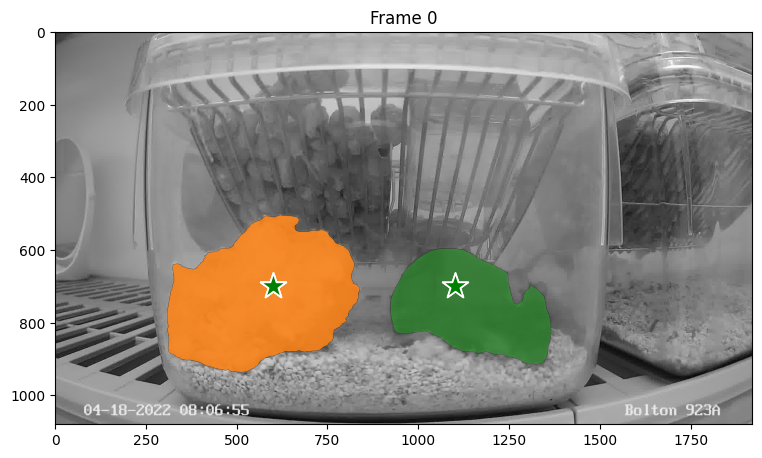

In [20]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 1) Define video_dir and collect frame names
video_dir = "./videos/18"
frame_names = [
    fn for fn in os.listdir(video_dir)
    if os.path.splitext(fn)[-1].lower() in [".jpg", ".jpeg"]
]
frame_names.sort(key=lambda x: int(os.path.splitext(x)[0]))  # numeric sort

print(f"Found {len(frame_names)} frames in {video_dir}.")

# 2) Choose the frame index you want to annotate
ann_frame_idx = 0  # for example, the first frame

# 3) Define the points/labels for your objects (nest, rat, etc.)
nest_obj_id = 1
nest_points = np.array([[600, 700]], dtype=np.float32)
nest_labels = np.array([1], np.int32)

rat_obj_id = 2
rat_points = np.array([[1100, 700]], dtype=np.float32)
rat_labels = np.array([1], np.int32)

# 4) Call your predictor methods (adjust these calls as needed)
prompts = {}
prompts[nest_obj_id] = (nest_points, nest_labels)
prompts[rat_obj_id] = (rat_points, rat_labels)

# Assume 'predictor' and 'inference_state' are already defined
# Example usage (pseudo-code; adjust to your environment):
_, nest_out_obj_ids, nest_out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=nest_obj_id,
    points=nest_points,
    labels=nest_labels,
)

_, rat_out_obj_ids, rat_out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=rat_obj_id,
    points=rat_points,
    labels=rat_labels,
)

# 5) Plot the frame along with the annotated points and masks
plt.figure(figsize=(9, 6))
plt.title(f"Frame {ann_frame_idx}")

# Load the image from the sorted frame list
img_path = os.path.join(video_dir, frame_names[ann_frame_idx])
plt.imshow(Image.open(img_path))

# Show nest points and masks
show_points(nest_points, nest_labels, plt.gca())
for i, out_obj_id in enumerate(nest_out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((nest_out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

# Show rat points and masks
show_points(rat_points, rat_labels, plt.gca())
for i, out_obj_id in enumerate(rat_out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((rat_out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

plt.show()


In [21]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }


if 0 in video_segments:
    del video_segments[0]

print(len(video_segments))

propagate in video: 100%|██████████| 3/3 [00:07<00:00,  2.62s/it]

2


In [ ]:
import os
import csv
import numpy as np
from math import sqrt
import cv2  # Required for contour processing

# Parameters for analysis
mouse_id = 2  # Object ID for the mouse
nest_id = 1  # Object ID for the nest
start_frame = 1  # Starting frame index
end_frame = 300  # Ending frame index
fps = 30  # Frames per second

# Fixed points
fixed_points = {
    "c1": (300, 950),
    "c2": (300, 200),
    "c3": (1400, 950),
    "c4": (1400, 200),
    "cage": (900, 620)
}

# Helper function to calculate centroid based on the main contour of the mask
def get_contour_center(mask):
    """Calculate the centroid based on the main contour of the mask."""
    mask = np.squeeze(mask)
    if mask.ndim != 2:
        raise ValueError("Mask must be a 2D binary array.")

    # Find contours in the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        moments = cv2.moments(largest_contour)
        if moments["m00"] != 0:
            center_x = moments["m10"] / moments["m00"]
            center_y = moments["m01"] / moments["m00"]
            return center_x, center_y
    return None

# Initialize dictionaries to store centroids, movement data, and distances
object_positions = {'mouse': {}, 'nest': {}}
nest_areas = {}  # Store areas of the nest for each frame
distances_to_points = {fp: {} for fp in fixed_points}  # Distances from fixed points
mouse_to_nest_distance = {}  # Distance between mouse and nest

# CSV file path
csv_file = "18.csv"

# Check if CSV file already exists
file_exists = os.path.exists(csv_file)

# Process each frame and calculate relevant metrics
for frame_idx in range(start_frame, end_frame + 1):
    frame_data = video_segments.get(frame_idx, {})

    # Mouse's centroid
    if mouse_id in frame_data:
        mouse_center = get_contour_center(frame_data[mouse_id])
        if mouse_center:
            object_positions['mouse'][frame_idx] = mouse_center

    # Nest's centroid and area
    if nest_id in frame_data:
        nest_mask = frame_data[nest_id]
        nest_center = get_contour_center(nest_mask)
        if nest_center:
            object_positions['nest'][frame_idx] = nest_center

        # Calculate nest area
        nest_area = np.count_nonzero(nest_mask)
        nest_areas[frame_idx] = nest_area

    # Calculate mouse-to-nest distance
    mouse_position = object_positions['mouse'].get(frame_idx)
    nest_position = object_positions['nest'].get(frame_idx)
    if mouse_position and nest_position:
        mouse_to_nest_distance[frame_idx] = sqrt(
            (nest_position[0] - mouse_position[0])**2 +
            (nest_position[1] - mouse_position[1])**2
        )

    # Calculate distances to fixed points
    for point_name, point_coords in fixed_points.items():
        if nest_position:
            distances_to_points[point_name][frame_idx] = {
                "nest_distance": sqrt((point_coords[0] - nest_position[0])**2 + (point_coords[1] - nest_position[1])**2),
                "mouse_distance": sqrt((point_coords[0] - mouse_position[0])**2 + (point_coords[1] - mouse_position[1])**2) if mouse_position else None
            }

# Open the CSV file in append mode if it already exists, else write new
with open(csv_file, mode='a', newline='') as file:
    writer = csv.writer(file)

    # Write header only if the file is being created (i.e., it doesn't exist)
    if not file_exists:
        header = [
            "Frame", 
            "Mouse_X", "Mouse_Y", "Nest_X", "Nest_Y",
            "Nest_Area"
        ]
        # Add headers for distances to fixed points
        for point_name in fixed_points:
            header.extend([f"{point_name}_Nest_Distance", f"{point_name}_Mouse_Distance"])
        # Add the "Mouse_To_Nest_Distance" column at the end
        header.append("Mouse_To_Nest_Distance")
        writer.writerow(header)

    # Write the details for each frame
    for frame_idx in range(start_frame, end_frame + 1):
        mouse_position = object_positions['mouse'].get(frame_idx, (None, None))
        nest_position = object_positions['nest'].get(frame_idx, (None, None))

        nest_area = nest_areas.get(frame_idx, None)

        # Collect distances for this frame
        distance_data = []
        for point_name in fixed_points:
            distance_info = distances_to_points[point_name].get(frame_idx, {})
            distance_data.extend([
                distance_info.get("nest_distance", None),
                distance_info.get("mouse_distance", None)
            ])

        # Prepare the row
        row = [
            frame_idx,
            mouse_position[0], mouse_position[1],
            nest_position[0], nest_position[1],
            nest_area
        ] + distance_data  # Add distances to fixed points
        row.append(mouse_to_nest_distance.get(frame_idx, None))  # Add mouse-to-nest distance

        writer.writerow(row)

print(f"CSV file '18.csv' has been created or updated.")

CSV file '18.csv' has been created or updated.


In [ ]:
import os
import csv
import numpy as np
from math import sqrt, atan2, degrees
import cv2  # Required for contour processing

# Parameters for analysis
mouse_id = 2  # Object ID for the mouse
nest_id = 1  # Object ID for the nest
start_frame = 0  # Starting frame index
end_frame = 2720  # Ending frame index
fps = 30  # Frames per second

# Fixed points
fixed_points = {
    "c1": (300, 950),
    "c2": (300, 200),
    "c3": (1400, 950),
    "c4": (1400, 200),
    "cage": (900, 620)
}

# Manually labeled activities
manually_labeled_activities = [
    ("NB", 0, 318),
    ("E", 319, 643),
    ("O", 644, 862),
    ("NB", 863, 1649),
    ("O", 1650, 1738),
    ("E", 1739, 1754),
    ("O", 1755, 1791),
    ("NB", 1792, 1910),
    ("O", 1911, 1993),
    ("NB", 1994, 2024),
]

# Helper function to find the activity for a given frame
def get_activity_for_frame(frame_idx, activities):
    """Return the activity corresponding to a frame index."""
    for activity, start, end in activities:
        if start <= frame_idx <= end:
            return activity
    return None  # If no activity is found, return None

# Initialize dictionaries to store centroids, movement data, and distances
object_positions = {'mouse': {}, 'nest': {}}
object_movement = {'mouse': {}, 'nest': {}}
nest_areas = {}  # Store areas of the nest for each frame
absolute_area_differences = {}  # Store absolute area differences
distances_to_points = {fp: {} for fp in fixed_points}  # Distances from fixed points
mouse_to_nest_distance = {}  # Distance between mouse and nest

# Helper function to calculate centroid based on the main contour of the mask
def get_contour_center(mask):
    """Calculate the centroid based on the main contour of the mask."""
    mask = np.squeeze(mask)
    if mask.ndim != 2:
        raise ValueError("Mask must be a 2D binary array.")

    # Find contours in the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        moments = cv2.moments(largest_contour)
        if moments["m00"] != 0:
            center_x = moments["m10"] / moments["m00"]
            center_y = moments["m01"] / moments["m00"]
            return center_x, center_y
    return None

# Process each frame and calculate relevant metrics
previous_area = None
for frame_idx in range(start_frame, end_frame + 1):
    frame_data = video_segments.get(frame_idx, {})

    # Mouse's centroid
    if mouse_id in frame_data:
        mouse_center = get_contour_center(frame_data[mouse_id])
        if mouse_center:
            object_positions['mouse'][frame_idx] = mouse_center

    # Nest's centroid and area
    if nest_id in frame_data:
        nest_mask = frame_data[nest_id]
        nest_center = get_contour_center(nest_mask)
        if nest_center:
            object_positions['nest'][frame_idx] = nest_center

        # Calculate nest area
        nest_area = np.count_nonzero(nest_mask)
        nest_areas[frame_idx] = nest_area

        # Calculate absolute area difference
        if previous_area is not None:
            absolute_area_differences[frame_idx] = abs(nest_area - previous_area)
        previous_area = nest_area

    # Calculate mouse-to-nest distance
    mouse_position = object_positions['mouse'].get(frame_idx)
    nest_position = object_positions['nest'].get(frame_idx)
    if mouse_position and nest_position:
        mouse_to_nest_distance[frame_idx] = sqrt(
            (nest_position[0] - mouse_position[0])**2 +
            (nest_position[1] - mouse_position[1])**2
        )

    # Calculate distances to fixed points
    for point_name, point_coords in fixed_points.items():
        if nest_position:
            distances_to_points[point_name][frame_idx] = {
                "nest_distance": sqrt((point_coords[0] - nest_position[0])**2 + (point_coords[1] - nest_position[1])**2),
                "mouse_distance": sqrt((point_coords[0] - mouse_position[0])**2 + (point_coords[1] - mouse_position[1])**2) if mouse_position else None
            }

# Calculate displacement, speed, and direction for both mouse and nest
for obj in ['mouse', 'nest']:
    previous_center = None
    for frame_idx in sorted(object_positions[obj].keys()):
        current_center = object_positions[obj][frame_idx]

        if previous_center is not None:
            displacement = sqrt((current_center[0] - previous_center[0]) ** 2 +
                                (current_center[1] - previous_center[1]) ** 2)
            speed = displacement * fps
            delta_x, delta_y = np.array(current_center) - np.array(previous_center)
            direction = degrees(atan2(delta_y, delta_x))

            object_movement[obj][frame_idx] = {
                'displacement': displacement,
                'speed': speed,
                'direction': direction,
                'position': current_center
            }

        previous_center = current_center

# Export details to CSV
csv_file = "frame_details_all_manuallyupdated.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    header = [
        "Frame", 
        "Mouse_X", "Mouse_Y", "Mouse_Displacement", "Mouse_Speed",
        "Nest_X", "Nest_Y", "Nest_Displacement", "Nest_Speed",
        "Nest_Area", "Absolute_Area_Difference"
    ]
    # Add headers for distances to fixed points
    for point_name in fixed_points:
        header.extend([f"{point_name}_Nest_Distance", f"{point_name}_Mouse_Distance"])
    # Add the "Mouse_To_Nest_Distance" and "Manually_Labeled_Activity" columns at the end
    header.extend(["Mouse_To_Nest_Distance", "Manually_Labeled_Activity"])
    writer.writerow(header)

    # Write the details for each frame
    for frame_idx in range(start_frame, end_frame + 1):
        mouse_position = object_positions['mouse'].get(frame_idx, (None, None))
        mouse_data = object_movement['mouse'].get(frame_idx, {})

        nest_position = object_positions['nest'].get(frame_idx, (None, None))
        nest_data = object_movement['nest'].get(frame_idx, {})

        nest_area = nest_areas.get(frame_idx, None)
        area_difference = absolute_area_differences.get(frame_idx, None)

        # Collect distances for this frame
        distance_data = []
        for point_name in fixed_points:
            distance_info = distances_to_points[point_name].get(frame_idx, {})
            distance_data.extend([
                distance_info.get("nest_distance", None),
                distance_info.get("mouse_distance", None)
            ])

        # Get manually labeled activity for the current frame
        activity = get_activity_for_frame(frame_idx, manually_labeled_activities)

        # Prepare the row
        row = [
            frame_idx,
            mouse_position[0], mouse_position[1],
            mouse_data.get('displacement', None),
            mouse_data.get('speed', None),
            nest_position[0], nest_position[1],
            nest_data.get('displacement', None),
            nest_data.get('speed', None),
            nest_area, area_difference
        ] + distance_data  # Add distances to fixed points
        row.extend([
            mouse_to_nest_distance.get(frame_idx, None),  # Add mouse-to-nest distance
            activity  # Add manually labeled activity
        ])

        writer.writerow(row)

print(f"Frame details with manually labeled activities exported to {csv_file}")


In [ ]:
import pandas as pd

# Load the CSV file
csv_file = "frame_details_all_manuallyupdated.csv"
df = pd.read_csv(csv_file)

# Ensure "cage_Mouse_Distance" column exists, assign recent value if missing
if "cage_Mouse_Distance" not in df.columns:
    df["cage_Mouse_Distance"] = None  # Initialize with None

df["cage_Mouse_Distance"].fillna(method='ffill', inplace=True)  # Forward fill missing values

# Initialize new columns
cage_mouse_diff = []
cage_mouse_avg = []

# Process in chunks of 10 frames
window_size = 10
for i in range(0, len(df), window_size):
    window = df.iloc[i:i + window_size]
    
    if len(window) < 2:
        cage_mouse_diff.extend([None] * len(window))
        cage_mouse_avg.extend([None] * len(window))
        continue
    
    # Calculate differences between consecutive frames
    differences = window["cage_Mouse_Distance"].diff().fillna(0).abs()
    average_diff = differences.mean()
    
    # Extend the lists with calculated values
    cage_mouse_diff.extend(differences.tolist())
    cage_mouse_avg.extend([average_diff] * len(window))

# Add new columns to DataFrame
df["Cage_Mouse_Distance_Difference"] = cage_mouse_diff
df["Cage_Mouse_Distance_Average"] = cage_mouse_avg

# Save updated CSV
updated_csv_file = "frame_details_with_cage_mouse_diff.csv"
df.to_csv(updated_csv_file, index=False)

print(f"Updated CSV file saved as {updated_csv_file}")


In [ ]:
# Update the CSV export section to include the manually labeled activities
csv_file = "frame_details_all_manuallyupdated.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header
    header = [
        "Frame", 
        "Mouse_X", "Mouse_Y", "Mouse_Displacement", "Mouse_Speed",
        "Nest_X", "Nest_Y", "Nest_Displacement", "Nest_Speed",
        "Nest_Area", "Absolute_Area_Difference"
    ]
    # Add headers for distances to fixed points
    for point_name in fixed_points:
        header.extend([f"{point_name}_Nest_Distance", f"{point_name}_Mouse_Distance"])
    # Add the "Mouse_To_Nest_Distance" and "Manually_Labeled_Activity" columns at the end
    header.extend(["Mouse_To_Nest_Distance", "Manually_Labeled_Activity"])
    writer.writerow(header)
    
    # Write the details for each frame
    for frame_idx in range(start_frame, end_frame + 1):
        mouse_position = object_positions['mouse'].get(frame_idx, (None, None))
        mouse_data = object_movement['mouse'].get(frame_idx, {})
        
        nest_position = object_positions['nest'].get(frame_idx, (None, None))
        nest_data = object_movement['nest'].get(frame_idx, {})
        
        nest_area = nest_areas.get(frame_idx, None)
        area_difference = absolute_area_differences.get(frame_idx, None)
        
        # Collect distances for this frame
        distance_data = []
        for point_name in fixed_points:
            distance_info = distances_to_points[point_name].get(frame_idx, {})
            distance_data.extend([
                distance_info.get("nest_distance", None),
                distance_info.get("mouse_distance", None)
            ])
        
        # Get manually labeled activity for the current frame
        activity = get_activity_for_frame(frame_idx, manually_labeled_activities)
        
        # Prepare the row
        row = [
            frame_idx,
            mouse_position[0], mouse_position[1],
            mouse_data.get('displacement', None),
            mouse_data.get('speed', None),
            nest_position[0], nest_position[1],
            nest_data.get('displacement', None),
            nest_data.get('speed', None),
            nest_area, area_difference
        ] + distance_data  # Add distances to fixed points
        row.extend([
            mouse_to_nest_distance.get(frame_idx, None),  # Add mouse-to-nest distance
            activity  # Add manually labeled activity
        ])
        
        writer.writerow(row)

print(f"Frame details with manually labeled activities exported to {csv_file}")


In [ ]:
import os
import csv
import numpy as np
from math import sqrt, atan2, degrees
import cv2  # Required for contour processing

# Parameters
mouse_id = 2  # Object ID for the mouse
nest_id = 1  # Object ID for the nest
start_frame = 0  # Starting frame index
end_frame = 2720  # Ending frame index
fps = 30  # Frames per second

# Thresholds for activity detection
activity_threshold_nest_building_displacement = 2.67
activity_threshold_nest_building_speed = 22.516
activity_threshold_rat_displacement_off_nest = 4.97
activity_threshold_rat_displacement_eating = 4.32

# Manually labeled activities
manually_labeled_activities = [
    ("NB", 0, 318),
    ("E", 319, 643),
    ("O", 644, 862),
    ("NB", 863, 1649),
    ("O", 1650, 1738),
    ("E", 1739, 1754),
    ("O", 1755, 1791),
    ("NB", 1792, 1910),
    ("O", 1911, 1993),
    ("NB", 1994, 2024),
]

# Assign manual labels to each frame
frame_activities = {}
for activity, start, end in manually_labeled_activities:
    for frame_idx in range(start, end + 1):
        frame_activities[frame_idx] = activity

# Initialize dictionaries
object_positions = {'mouse': {}, 'nest': {}}
object_movement = {'mouse': {}, 'nest': {}}
nest_areas = {}
absolute_area_differences = {}
activities = {'NB': [], 'E': [], 'O': []}

# Helper function to calculate the centroid from the mask
def get_contour_center(mask):
    mask = np.squeeze(mask)
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        moments = cv2.moments(largest_contour)
        if moments["m00"] != 0:
            center_x = moments["m10"] / moments["m00"]
            center_y = moments["m01"] / moments["m00"]
            return center_x, center_y
    return None

# Calculate centroids and metrics
previous_area = None
for frame_idx in range(start_frame, end_frame + 1):
    frame_data = video_segments.get(frame_idx, {})

    # Mouse centroid
    if mouse_id in frame_data:
        mouse_center = get_contour_center(frame_data[mouse_id])
        if mouse_center:
            object_positions['mouse'][frame_idx] = mouse_center

    # Nest centroid and area
    if nest_id in frame_data:
        nest_mask = frame_data[nest_id]
        nest_center = get_contour_center(nest_mask)
        if nest_center:
            object_positions['nest'][frame_idx] = nest_center

        nest_area = np.count_nonzero(nest_mask)
        nest_areas[frame_idx] = nest_area

        # Absolute area difference
        if previous_area is not None:
            absolute_area_differences[frame_idx] = abs(nest_area - previous_area)
        previous_area = nest_area

# Calculate displacement, speed, and direction
for obj in ['mouse', 'nest']:
    previous_center = None
    for frame_idx in sorted(object_positions[obj].keys()):
        current_center = object_positions[obj][frame_idx]
        if previous_center is not None:
            displacement = sqrt((current_center[0] - previous_center[0]) ** 2 +
                                (current_center[1] - previous_center[1]) ** 2)
            speed = displacement * fps
            delta_x, delta_y = np.array(current_center) - np.array(previous_center)
            direction = degrees(atan2(delta_y, delta_x))

            object_movement[obj][frame_idx] = {
                'displacement': displacement,
                'speed': speed,
                'direction': direction,
                'position': current_center
            }
        previous_center = current_center

# Algorithm-labeled activity detection
for frame_idx in sorted(object_movement['nest'].keys()):
    nest_displacement = object_movement['nest'][frame_idx]['displacement']
    nest_speed = object_movement['nest'][frame_idx]['speed']
    mouse_displacement = object_movement['mouse'].get(frame_idx, {}).get('displacement', 0)

    if nest_displacement > activity_threshold_nest_building_displacement or nest_speed > activity_threshold_nest_building_speed:
        activities['NB'].append(frame_idx)
    elif nest_displacement < activity_threshold_nest_building_displacement and mouse_displacement < activity_threshold_rat_displacement_eating:
        activities['E'].append(frame_idx)
    elif nest_displacement < activity_threshold_nest_building_displacement and mouse_displacement > activity_threshold_rat_displacement_off_nest:
        activities['O'].append(frame_idx)

# Export details to CSV
csv_file = "frame_details_with_manual_and_algorithmic_activities.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow([
        "Frame",
        "Mouse_X", "Mouse_Y", "Mouse_Displacement", "Mouse_Speed",
        "Nest_X", "Nest_Y", "Nest_Displacement", "Nest_Speed",
        "Nest_Area", "Absolute_Area_Difference",
        "Manual_Label", "Algorithm_Label"
    ])

    # Write data for each frame
    for frame_idx in range(start_frame, end_frame + 1):
        mouse_data = object_movement['mouse'].get(frame_idx, {})
        nest_data = object_movement['nest'].get(frame_idx, {})
        manual_label = frame_activities.get(frame_idx, "Unlabeled")
        algorithm_label = None
        for activity_type, frames in activities.items():
            if frame_idx in frames:
                algorithm_label = activity_type
                break

        writer.writerow([
            frame_idx,
            mouse_data.get('position', (None, None))[0],
            mouse_data.get('position', (None, None))[1],
            mouse_data.get('displacement', None),
            mouse_data.get('speed', None),
            nest_data.get('position', (None, None))[0],
            nest_data.get('position', (None, None))[1],
            nest_data.get('displacement', None),
            nest_data.get('speed', None),
            nest_areas.get(frame_idx, None),
            absolute_area_differences.get(frame_idx, None),
            manual_label,
            algorithm_label
        ])

print(f"Frame details with metrics and activities exported to {csv_file}")


In [ ]:
# Export details to CSV and calculate accuracy
csv_file = "accuracy.csv"
correct_predictions = 0
total_frames = 0

with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow([
        "Frame",
        "Mouse_X", "Mouse_Y", "Mouse_Displacement", "Mouse_Speed",
        "Nest_X", "Nest_Y", "Nest_Displacement", "Nest_Speed",
        "Nest_Area", "Absolute_Area_Difference",
        "Manual_Label", "Algorithm_Label"
    ])

    # Write data for each frame
    for frame_idx in range(start_frame, end_frame + 1):
        mouse_data = object_movement['mouse'].get(frame_idx, {})
        nest_data = object_movement['nest'].get(frame_idx, {})
        manual_label = frame_activities.get(frame_idx, "Unlabeled")
        algorithm_label = None
        for activity_type, frames in activities.items():
            if frame_idx in frames:
                algorithm_label = activity_type
                break

        # Compare manual and algorithm labels
        if manual_label == algorithm_label:
            correct_predictions += 1
        total_frames += 1

        writer.writerow([
            frame_idx,
            mouse_data.get('position', (None, None))[0],
            mouse_data.get('position', (None, None))[1],
            mouse_data.get('displacement', None),
            mouse_data.get('speed', None),
            nest_data.get('position', (None, None))[0],
            nest_data.get('position', (None, None))[1],
            nest_data.get('displacement', None),
            nest_data.get('speed', None),
            nest_areas.get(frame_idx, None),
            absolute_area_differences.get(frame_idx, None),
            manual_label,
            algorithm_label
        ])

# Calculate accuracy
accuracy = (correct_predictions / total_frames) * 100 if total_frames > 0 else 0

# Display accuracy in terminal
print(f"Frame details with metrics and activities exported to {csv_file}")
print(f"Accuracy of the algorithm: {accuracy:.2f}%")



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load datasets
df1 = pd.read_csv("frame_details_with_cage_mouse_diff.csv")
df2 = pd.read_csv("19CL4.csv")
df_test = pd.read_csv("18CL4.csv")

# Combine training data
df_train = pd.concat([df1, df2], ignore_index=True)
df_train = df_train.dropna(subset=['Manually_Labeled_Activity'])

# Visualize Mouse_X distribution across labels
plt.figure(figsize=(10, 6))
sns.boxplot(x='Manually_Labeled_Activity', y='Mouse_X', data=df_train)
plt.title("Distribution of Mouse_X across Activity Labels")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Encode activity labels
label_encoder = LabelEncoder()
df_train['Activity_Label'] = label_encoder.fit_transform(df_train['Manually_Labeled_Activity'])

# Feature engineering: Bin Mouse_X into quartiles
df_train['Mouse_X_Bin'] = pd.qcut(df_train['Mouse_X'], q=4, duplicates='drop', labels=False)

# Prepare training features
train_features = df_train.drop(columns=['Frame', 'Frames', 'Manually_Labeled_Activity', 'Activity_Label'], errors='ignore')
train_features = train_features.fillna(train_features.median())
train_features['Mouse_X_Bin'] = df_train['Mouse_X_Bin']

# Prepare test set
df_test = df_test.dropna(subset=['Manually_Labeled_Activity'])
df_test['Activity_Label'] = label_encoder.transform(df_test['Manually_Labeled_Activity'])

# Bin Mouse_X in test set based on training quantiles
mouse_x_bins = np.quantile(df_train['Mouse_X'].dropna(), q=[0, 0.25, 0.5, 0.75, 1.0])
df_test['Mouse_X_Bin'] = pd.cut(df_test['Mouse_X'], bins=mouse_x_bins, include_lowest=True, labels=False)

# Prepare test features
test_features = df_test.drop(columns=['Frame', 'Frames', 'Manually_Labeled_Activity', 'Activity_Label'], errors='ignore')
test_features = test_features.reindex(columns=train_features.columns, fill_value=np.nan)
test_features = test_features.fillna(train_features.median())
test_features['Mouse_X_Bin'] = df_test['Mouse_X_Bin']

# Define reduced hyperparameter grid
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# Initialize and run grid search
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(train_features, df_train['Activity_Label'])

# Train best model
best_rf = grid_search.best_estimator_
train_preds = best_rf.predict(train_features)
train_acc = accuracy_score(df_train['Activity_Label'], train_preds)

# Predict on test set
test_preds = best_rf.predict(test_features)
test_acc = accuracy_score(df_test['Activity_Label'], test_preds)

conf_matrix = confusion_matrix(df_test['Activity_Label'], test_preds)
conf_matrix_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)
class_report = classification_report(df_test['Activity_Label'], test_preds, target_names=label_encoder.classes_)

# Save predictions
df_test['Predicted_Activity_Label'] = test_preds
df_test['Predicted_Activity'] = label_encoder.inverse_transform(test_preds)
df_test.to_csv("18CL4_with_optimized_predictions.csv", index=False)

# Print results
print("Best Parameters:", grid_search.best_params_)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_df)
print("\nClassification Report:\n", class_report)


In [ ]:
# Parameters
fps = 30  # Frame rate in frames per second

# Initialize activity logs
activities = {'Nest Building': [], 'Eating': [], 'Off-Nest': []}

# Sort frame indices for processing
frame_indices = sorted(object_movement['nest'].keys())

# Process each frame to detect activities
for frame_idx in frame_indices:
    # Retrieve nest and rat metrics with safe checks
    nest_metrics = object_movement['nest'].get(frame_idx, {})
    rat_metrics = object_movement['rat'].get(frame_idx, {})
    
    nest_displacement = nest_metrics.get('displacement', 0)
    nest_speed = nest_metrics.get('speed', 0)
    rat_displacement = rat_metrics.get('displacement', 0)
    rat_speed = rat_metrics.get('speed', 0)
    absolute_area_difference = nest_metrics.get('absolute_area_difference', 0)

    # Detect Activity: Nest Building (NB)
    if (0.656145582 <= rat_displacement <= 539.3380448) and \
       (19.68436745 <= rat_speed <= 16180.14134) and \
       (0.026541454 <= nest_displacement <= 311.0493448) and \
       (0.796243611 <= nest_speed <= 9331.480343) and \
       (0.0 <= absolute_area_difference <= 67294.0):
        if not activities['Nest Building'] or activities['Nest Building'][-1]['end_frame'] < frame_idx - 1:
            # Start a new activity
            activities['Nest Building'].append({
                'start_frame': frame_idx,
                'end_frame': frame_idx  # Temporarily set end frame
            })
        else:
            # Extend the ongoing activity
            activities['Nest Building'][-1]['end_frame'] = frame_idx

    # Detect Activity: Eating (E)
    elif (0.026165583 <= rat_displacement <= 73.53876507) and \
         (0.784967504 <= rat_speed <= 2206.162952) and \
         (0.010604042 <= nest_displacement <= 12.10417058) and \
         (0.318121252 <= nest_speed <= 363.1251174) and \
         (2.0 <= absolute_area_difference <= 6378.0):
        if not activities['Eating'] or activities['Eating'][-1]['end_frame'] < frame_idx - 1:
            activities['Eating'].append({
                'start_frame': frame_idx,
                'end_frame': frame_idx
            })
        else:
            activities['Eating'][-1]['end_frame'] = frame_idx

    # Detect Activity: Off-Nest (O)
    elif (0.110642167 <= rat_displacement <= 261.6894571) and \
         (3.319265011 <= rat_speed <= 7850.683712) and \
         (0.023649955 <= nest_displacement <= 30.21159562) and \
         (0.709498654 <= nest_speed <= 906.3478687) and \
         (1.0 <= absolute_area_difference <= 20019.0):
        if not activities['Off-Nest'] or activities['Off-Nest'][-1]['end_frame'] < frame_idx - 1:
            activities['Off-Nest'].append({
                'start_frame': frame_idx,
                'end_frame': frame_idx
            })
        else:
            activities['Off-Nest'][-1]['end_frame'] = frame_idx

# Merge activities if the gap between two is 1 or 0 frames
for activity_type, activity_list in activities.items():
    merged_activities = []
    for i, activity in enumerate(activity_list):
        if i == 0:
            merged_activities.append(activity)
        else:
            previous_activity = merged_activities[-1]
            if activity['start_frame'] - previous_activity['end_frame'] <= 1:
                # Merge with the previous activity
                previous_activity['end_frame'] = activity['end_frame']
            else:
                # Start a new merged activity
                merged_activities.append(activity)
    activities[activity_type] = merged_activities

# Add timestamps and durations for each activity
for activity_type, activity_list in activities.items():
    for activity in activity_list:
        start_time_sec = activity['start_frame'] / fps
        end_time_sec = activity['end_frame'] / fps
        duration_frames = activity['end_frame'] - activity['start_frame'] + 1  # Inclusive duration

        # Update activity with formatted time and duration
        activity.update({
            'type': activity_type,
            'start_time': f"{activity['start_frame']} (frame) / {start_time_sec:.2f} sec",
            'end_time': f"{activity['end_frame']} (frame) / {end_time_sec:.2f} sec",
            'duration': f"{duration_frames} frames / {duration_frames / fps:.2f} sec"
        })

# Collect and sort all activities by start_frame for sequential display
all_activities = [
    {
        'type': activity['type'],
        'start_time': activity['start_time'],
        'end_time': activity['end_time'],
        'duration': activity['duration']
    }
    for activity_type, activity_list in activities.items()
    for activity in activity_list
]

all_activities = sorted(all_activities, key=lambda x: int(x['start_time'].split()[0]))

# Display detected activities
print("Detected Activities:")
for activity in all_activities:
    print(f"{activity['type']}: from {activity['start_time']} to {activity['end_time']}, Duration: {activity['duration']}")


In [ ]:
#1
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from math import sqrt, atan2, degrees
import cv2  # Required for contour processing

# Parameters for analysis
rat_id = 2  # Object ID for the rat
nest_id = 1  # Object ID for the nest
start_frame = 0  # Starting frame index
end_frame = 2720  # Ending frame index
fps = 30  # Frames per second

# Initialize dictionaries to store centroids, movement data, and inside-nest status
object_positions = {'rat': {}, 'nest': {}}
object_movement = {'rat': {}, 'nest': {}}
distance_between_centroids = {}  # Store distances between rat and nest centroids for each frame
inside_nest_status = {}  # Store whether the rat is inside the nest for each frame

# Helper function to calculate centroid based on the main contour of the mask
def get_contour_center(mask):
    """Calculate the centroid based on the main contour of the mask."""
    mask = np.squeeze(mask)
    if mask.ndim != 2:
        raise ValueError("Mask must be a 2D binary array.")
    
    # Find contours in the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        moments = cv2.moments(largest_contour)
        if moments["m00"] != 0:
            center_x = moments["m10"] / moments["m00"]
            center_y = moments["m01"] / moments["m00"]
            return center_x, center_y
    return None

# Calculate centroids and check for overlap in each frame
for frame_idx in range(start_frame, end_frame + 1):
    frame_data = video_segments.get(frame_idx, {})
    
    # Rat's centroid
    if rat_id in frame_data:
        rat_center = get_contour_center(frame_data[rat_id])
        if rat_center:
            object_positions['rat'][frame_idx] = rat_center

    # Nest's centroid
    if nest_id in frame_data:
        nest_center = get_contour_center(frame_data[nest_id])
        if nest_center:
            object_positions['nest'][frame_idx] = nest_center

    # Calculate the distance between the rat and nest centroids if both are present
    if frame_idx in object_positions['rat'] and frame_idx in object_positions['nest']:
        rat_position = object_positions['rat'][frame_idx]
        nest_position = object_positions['nest'][frame_idx]
        distance = sqrt((rat_position[0] - nest_position[0]) ** 2 +
                        (rat_position[1] - nest_position[1]) ** 2)
        distance_between_centroids[frame_idx] = distance

# Calculate displacement, speed, and direction for both rat and nest
for obj in ['rat', 'nest']:
    previous_center = None
    for frame_idx in sorted(object_positions[obj].keys()):
        current_center = object_positions[obj][frame_idx]
        
        if previous_center is not None:
            displacement = sqrt((current_center[0] - previous_center[0]) ** 2 +
                                (current_center[1] - previous_center[1]) ** 2)
            speed = displacement * fps
            delta_x, delta_y = np.array(current_center) - np.array(previous_center)
            direction = degrees(atan2(delta_y, delta_x))
            
            object_movement[obj][frame_idx] = {
                'displacement': displacement,
                'speed': speed,
                'direction': direction,
                'position': current_center
            }
        
        previous_center = current_center

# Visualization: Display metrics on frames
plt.close("all")
for frame_idx in range(start_frame, end_frame + 1):
    frame_path = os.path.join(video_dir, f"{frame_idx:05d}.jpg")
    img = Image.open(frame_path)
    plt.figure(figsize=(6, 4))
    plt.title(f"Frame {frame_idx}")
    plt.imshow(img)
    
    # Plot centroids and overlay metrics for the rat
    if frame_idx in object_positions['rat']:
        rat_position = object_positions['rat'][frame_idx]
        plt.plot(rat_position[0], rat_position[1], 'ro')  # Red dot for the rat
        
        if frame_idx in object_movement['rat']:
            rat_movement = object_movement['rat'][frame_idx]
            plt.text(10, 30, f"Mouse Displacement: {rat_movement['displacement']:.2f} px", color="red")
            plt.text(10, 80, f"Mouse Speed: {rat_movement['speed']:.2f} px/s", color="red")
            plt.text(10, 130, f"Mouse Position: {rat_movement['position']}", color="red")
    
    # Plot centroids and metrics for the nest
    if frame_idx in object_positions['nest']:
        nest_position = object_positions['nest'][frame_idx]
        plt.plot(nest_position[0], nest_position[1], 'bo')  # Blue dot for the nest
        
        if frame_idx in object_movement['nest']:
            nest_movement = object_movement['nest'][frame_idx]
            plt.text(10, 190, f"Nest Displacement: {nest_movement['displacement']:.2f} px", color="blue")
            plt.text(10, 240, f"Nest Speed: {nest_movement['speed']:.2f} px/s", color="blue")
            plt.text(10, 290, f"Nest Position: {nest_movement['position']}", color="blue")


    # Display the frame with annotations
    plt.axis("off")
    plt.show()


In [ ]:
#manually activity updated in csv file
import os
import csv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from math import sqrt, atan2, degrees
import cv2  # Required for contour processing

# Parameters for analysis
mouse_id = 2  # Object ID for the mouse
nest_id = 1  # Object ID for the nest
start_frame = 0  # Starting frame index
end_frame = 2720  # Ending frame index
fps = 30  # Frames per second

# Manually labeled activities
manually_labeled_activities = [
    ("NB", 0, 318),
    ("E", 319, 643),
    ("O", 644, 862),
    ("NB", 863, 1649),
    ("O", 1650, 1738),
    ("E", 1739, 1754),
    ("O", 1755, 1791),
    ("NB", 1792, 1910),
    ("O", 1911, 1993),
    ("NB", 1994, 2024),
]

# Assign activity labels to each frame
frame_activities = {}
for activity, start, end in manually_labeled_activities:
    for frame_idx in range(start, end + 1):
        frame_activities[frame_idx] = activity

# Initialize dictionaries to store centroids, movement data, and inside-nest status
object_positions = {'mouse': {}, 'nest': {}}
object_movement = {'mouse': {}, 'nest': {}}
nest_areas = {}  # Store areas of the nest for each frame
absolute_area_differences = {}  # Store absolute area differences

# Helper function to calculate centroid based on the main contour of the mask
def get_contour_center(mask):
    """Calculate the centroid based on the main contour of the mask."""
    mask = np.squeeze(mask)
    if mask.ndim != 2:
        raise ValueError("Mask must be a 2D binary array.")
    
    # Find contours in the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        moments = cv2.moments(largest_contour)
        if moments["m00"] != 0:
            center_x = moments["m10"] / moments["m00"]
            center_y = moments["m01"] / moments["m00"]
            return center_x, center_y
    return None

# Calculate centroids and areas of the nest in each frame
previous_area = None
for frame_idx in range(start_frame, end_frame + 1):
    frame_data = video_segments.get(frame_idx, {})
    
    # Mouse's centroid
    if mouse_id in frame_data:
        mouse_center = get_contour_center(frame_data[mouse_id])
        if mouse_center:
            object_positions['mouse'][frame_idx] = mouse_center

    # Nest's centroid and area
    if nest_id in frame_data:
        nest_mask = frame_data[nest_id]
        nest_center = get_contour_center(nest_mask)
        if nest_center:
            object_positions['nest'][frame_idx] = nest_center
        
        # Calculate nest area
        nest_area = np.count_nonzero(nest_mask)
        nest_areas[frame_idx] = nest_area
        
        # Calculate absolute area difference
        if previous_area is not None:
            absolute_area_differences[frame_idx] = abs(nest_area - previous_area)
        previous_area = nest_area

# Calculate displacement, speed, and direction for both mouse and nest
for obj in ['mouse', 'nest']:
    previous_center = None
    for frame_idx in sorted(object_positions[obj].keys()):
        current_center = object_positions[obj][frame_idx]
        
        if previous_center is not None:
            displacement = sqrt((current_center[0] - previous_center[0]) ** 2 +
                                (current_center[1] - previous_center[1]) ** 2)
            speed = displacement * fps
            delta_x, delta_y = np.array(current_center) - np.array(previous_center)
            direction = degrees(atan2(delta_y, delta_x))
            
            object_movement[obj][frame_idx] = {
                'displacement': displacement,
                'speed': speed,
                'direction': direction,
                'position': current_center
            }
        
        previous_center = current_center

# Export details to CSV
csv_file = "frame_details_with_activities.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header
    writer.writerow([
        "Frame", 
        "Mouse_X", "Mouse_Y", "Mouse_Displacement", "Mouse_Speed",
        "Nest_X", "Nest_Y", "Nest_Displacement", "Nest_Speed",
        "Nest_Area", "Absolute_Area_Difference", "Activity_Label"
    ])
    
    # Write the details for each frame
    for frame_idx in range(start_frame, end_frame + 1):
        mouse_position = object_positions['mouse'].get(frame_idx, (None, None))
        mouse_data = object_movement['mouse'].get(frame_idx, {})
        
        nest_position = object_positions['nest'].get(frame_idx, (None, None))
        nest_data = object_movement['nest'].get(frame_idx, {})
        
        nest_area = nest_areas.get(frame_idx, None)
        area_difference = absolute_area_differences.get(frame_idx, None)
        activity_label = frame_activities.get(frame_idx, "Unlabeled")  # Default to "Unlabeled"
        
        writer.writerow([
            frame_idx,
            mouse_position[0], mouse_position[1],
            mouse_data.get('displacement', None),
            mouse_data.get('speed', None),
            nest_position[0], nest_position[1],
            nest_data.get('displacement', None),
            nest_data.get('speed', None),
            nest_area, area_difference, activity_label
        ])

print(f"Frame details with activities exported to {csv_file}")


In [ ]:
import os
import csv
import numpy as np
from math import sqrt, atan2, degrees
import cv2  # Required for contour processing

# Parameters
mouse_id = 2  # Object ID for the mouse
nest_id = 1  # Object ID for the nest
start_frame = 0  # Starting frame index
end_frame = 2720  # Ending frame index
fps = 30  # Frames per second

# Thresholds for activity detection
activity_threshold_nest_building_displacement = 3
activity_threshold_nest_building_speed = 23
activity_threshold_rat_displacement_off_nest = 4
activity_threshold_rat_displacement_eating = 4

# Manually labeled activities
manually_labeled_activities = [
    ("NB", 0, 318),
    ("E", 319, 643),
    ("O", 644, 862),
    ("NB", 863, 1649),
    ("O", 1650, 1738),
    ("E", 1739, 1754),
    ("O", 1755, 1791),
    ("NB", 1792, 1910),
    ("O", 1911, 1993),
    ("NB", 1994, 2024),
]

# Assign manual labels to each frame
frame_activities = {}
for activity, start, end in manually_labeled_activities:
    for frame_idx in range(start, end + 1):
        frame_activities[frame_idx] = activity

# Initialize dictionaries
object_positions = {'mouse': {}, 'nest': {}}
object_movement = {'mouse': {}, 'nest': {}}
nest_areas = {}
absolute_area_differences = {}
activities = {'Nest Building': [], 'Eating': [], 'Off-Nest': []}

# Helper function to calculate the centroid from the mask
def get_contour_center(mask):
    mask = np.squeeze(mask)
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        moments = cv2.moments(largest_contour)
        if moments["m00"] != 0:
            center_x = moments["m10"] / moments["m00"]
            center_y = moments["m01"] / moments["m00"]
            return center_x, center_y
    return None

# Calculate centroids and metrics
previous_area = None
for frame_idx in range(start_frame, end_frame + 1):
    frame_data = video_segments.get(frame_idx, {})

    # Mouse centroid
    if mouse_id in frame_data:
        mouse_center = get_contour_center(frame_data[mouse_id])
        if mouse_center:
            object_positions['mouse'][frame_idx] = mouse_center

    # Nest centroid and area
    if nest_id in frame_data:
        nest_mask = frame_data[nest_id]
        nest_center = get_contour_center(nest_mask)
        if nest_center:
            object_positions['nest'][frame_idx] = nest_center

        nest_area = np.count_nonzero(nest_mask)
        nest_areas[frame_idx] = nest_area

        # Absolute area difference
        if previous_area is not None:
            absolute_area_differences[frame_idx] = abs(nest_area - previous_area)
        previous_area = nest_area

# Calculate displacement, speed, and direction
for obj in ['mouse', 'nest']:
    previous_center = None
    for frame_idx in sorted(object_positions[obj].keys()):
        current_center = object_positions[obj][frame_idx]
        if previous_center is not None:
            displacement = sqrt((current_center[0] - previous_center[0]) ** 2 +
                                (current_center[1] - previous_center[1]) ** 2)
            speed = displacement * fps
            delta_x, delta_y = np.array(current_center) - np.array(previous_center)
            direction = degrees(atan2(delta_y, delta_x))

            object_movement[obj][frame_idx] = {
                'displacement': displacement,
                'speed': speed,
                'direction': direction,
                'position': current_center
            }
        previous_center = current_center

# Algorithm-labeled activity detection
for frame_idx in sorted(object_movement['nest'].keys()):
    nest_displacement = object_movement['nest'][frame_idx]['displacement']
    nest_speed = object_movement['nest'][frame_idx]['speed']
    mouse_displacement = object_movement['mouse'].get(frame_idx, {}).get('displacement', 0)

    if nest_displacement > activity_threshold_nest_building_displacement or nest_speed > activity_threshold_nest_building_speed:
        activities['Nest Building'].append(frame_idx)
    elif nest_displacement < activity_threshold_nest_building_displacement and mouse_displacement < activity_threshold_rat_displacement_eating:
        activities['Eating'].append(frame_idx)
    elif nest_displacement < activity_threshold_nest_building_displacement and mouse_displacement > activity_threshold_rat_displacement_off_nest:
        activities['Off-Nest'].append(frame_idx)

# Export details to CSV
csv_file = "frame_details_with_manual_and_algorithmic_activities.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow([
        "Frame",
        "Mouse_X", "Mouse_Y", "Mouse_Displacement", "Mouse_Speed",
        "Nest_X", "Nest_Y", "Nest_Displacement", "Nest_Speed",
        "Nest_Area", "Absolute_Area_Difference",
        "Manual_Label", "Algorithm_Label"
    ])

    # Write data for each frame
    for frame_idx in range(start_frame, end_frame + 1):
        mouse_data = object_movement['mouse'].get(frame_idx, {})
        nest_data = object_movement['nest'].get(frame_idx, {})
        manual_label = frame_activities.get(frame_idx, "Unlabeled")
        algorithm_label = None
        for activity_type, frames in activities.items():
            if frame_idx in frames:
                algorithm_label = activity_type
                break

        writer.writerow([
            frame_idx,
            mouse_data.get('position', (None, None))[0],
            mouse_data.get('position', (None, None))[1],
            mouse_data.get('displacement', None),
            mouse_data.get('speed', None),
            nest_data.get('position', (None, None))[0],
            nest_data.get('position', (None, None))[1],
            nest_data.get('displacement', None),
            nest_data.get('speed', None),
            nest_areas.get(frame_idx, None),
            absolute_area_differences.get(frame_idx, None),
            manual_label,
            algorithm_label
        ])

print(f"Frame details with metrics and activities exported to {csv_file}")


In [ ]:
# Parameters
activity_threshold_nest_building_displacement = 3  # Threshold for nest displacement to indicate nest-building activity
activity_threshold_nest_building_speed = 23  # Threshold for nest speed to indicate nest-building activity
activity_threshold_rat_displacement_off_nest = 4  # Threshold for rat displacement to classify as Off-Nest
activity_threshold_rat_displacement_eating = 4  # Threshold for rat displacement to classify as Eating

# Initialize activity logs
activities = {'Nest Building': [], 'Eating': [], 'Off-Nest': []}

# Process each frame to detect activities
frame_indices = sorted(object_movement['nest'].keys())

for frame_idx in frame_indices:
    # Retrieve nest metrics (ensure frame_idx exists)
    nest_displacement = object_movement['nest'][frame_idx]['displacement']
    nest_speed = object_movement['nest'][frame_idx]['speed']
    
    # Retrieve rat metrics with a safe check
    rat_displacement = (
        object_movement['mouse'][frame_idx]['displacement']
        if frame_idx in object_movement['mouse']
        else 0  # Default to 0 if frame does not exist
    )

    # Detect Activity: Nest Building
    if nest_displacement > activity_threshold_nest_building_displacement or nest_speed > activity_threshold_nest_building_speed:
        if not activities['Nest Building'] or activities['Nest Building'][-1]['end_frame'] < frame_idx - 1:
            start_frame = frame_idx
            activities['Nest Building'].append({
                'start_frame': start_frame,
                'end_frame': start_frame  # Temporarily set end frame
            })
        else:
            activities['Nest Building'][-1]['end_frame'] = frame_idx

    # Detect Activity: Eating
    elif nest_displacement < activity_threshold_nest_building_displacement and rat_displacement < activity_threshold_rat_displacement_eating:
        if not activities['Eating'] or activities['Eating'][-1]['end_frame'] < frame_idx - 1:
            start_frame = frame_idx
            activities['Eating'].append({
                'start_frame': start_frame,
                'end_frame': start_frame  # Temporarily set end frame
            })
        else:
            activities['Eating'][-1]['end_frame'] = frame_idx

    # Detect Activity: Off-Nest
    elif nest_displacement < activity_threshold_nest_building_displacement and rat_displacement > activity_threshold_rat_displacement_off_nest:
        if not activities['Off-Nest'] or activities['Off-Nest'][-1]['end_frame'] < frame_idx - 1:
            start_frame = frame_idx
            activities['Off-Nest'].append({
                'start_frame': start_frame,
                'end_frame': start_frame  # Temporarily set end frame
            })
        else:
            activities['Off-Nest'][-1]['end_frame'] = frame_idx

# Merge activities if the gap between two is 1 or 0 frames
for activity_type in activities.keys():
    merged_activities = []
    for i, activity in enumerate(activities[activity_type]):
        if i == 0:
            merged_activities.append(activity)
        else:
            previous_activity = merged_activities[-1]
            if activity['start_frame'] - previous_activity['end_frame'] <= 1:
                # Merge with the previous activity
                previous_activity['end_frame'] = activity['end_frame']
            else:
                merged_activities.append(activity)
    activities[activity_type] = merged_activities

# Calculate timestamps and durations for each activity
fps = 30  # Frame rate in frames per second
for activity_type in activities.keys():
    for activity in activities[activity_type]:
        start_time = activity['start_frame'] / fps
        end_time = activity['end_frame'] / fps
        activity_duration = activity['end_frame'] - activity['start_frame'] + 1  # Inclusive duration

        # Update activity dictionary with formatted time
        activity.update({
            'type': activity_type,
            'start_time': f"{activity['start_frame']} (frame)",
            'end_time': f"{activity['end_frame']} (frame)",
            'duration': f"{activity_duration} frames"
        })

# Collect and sort all activities by start_frame for sequential display
all_activities = []
for activity_type, activity_list in activities.items():
    for activity in activity_list:
        all_activities.append({
            'type': activity['type'],
            'start_time': activity['start_time'],
            'end_time': activity['end_time'],
            'duration': activity['duration']
        })

all_activities = sorted(all_activities, key=lambda x: int(x['start_time'].split()[0]))

# Display activities one after another in flow
print("Detected Activities:")
for activity in all_activities:
    print(f"{activity['type']}: from {activity['start_time']} to {activity['end_time']}, Duration: {activity['duration']}")


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from math import sqrt, atan2, degrees
import cv2  # Required for contour processing

# Parameters for analysis
rat_id = 2  # Object ID for the rat
nest_id = 1  # Object ID for the nest
start_frame = 0  # Starting frame index
end_frame = 600  # Ending frame index
fps = 1  # Frames per second
iou_threshold = 0.3  # Threshold for IoU to determine if rat is inside nest (e.g., 30% overlap)
moving_window_size = 10  # Number of frames to consider for the moving average
activity_threshold_nest_building = 4  # Threshold for displacement to indicate nest-building activity
activity_threshold_eating_drinking = 3  # Threshold for nest displacement to consider eating/drinking

# Initialize dictionaries to store centroids, movement data, and activities
object_positions = {'rat': {}, 'nest': {}}
object_movement = {'rat': {}, 'nest': {}}
distance_between_centroids = {}  # Store distances between rat and nest centroids for each frame
inside_nest_status = {}  # Store whether the rat is inside the nest for each frame
activities = {'activity1': [], 'activity2': [], 'activity3': []}  # Initialize activity logs

# Helper function to calculate centroid based on the main contour of the mask
def get_contour_center(mask):
    """Calculate the centroid based on the main contour of the mask."""
    mask = np.squeeze(mask)
    if mask.ndim != 2:
        raise ValueError("Mask must be a 2D binary array.")
    
    # Find contours in the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        moments = cv2.moments(largest_contour)
        if moments["m00"] != 0:
            center_x = moments["m10"] / moments["m00"]
            center_y = moments["m01"] / moments["m00"]
            return center_x, center_y
    return None

# Calculate centroids and check for overlap in each frame
for frame_idx in range(start_frame, end_frame + 1):
    frame_data = video_segments.get(frame_idx, {})
    
    # Rat's centroid
    if rat_id in frame_data:
        rat_center = get_contour_center(frame_data[rat_id])
        if rat_center:
            object_positions['rat'][frame_idx] = rat_center

    # Nest's centroid
    if nest_id in frame_data:
        nest_center = get_contour_center(frame_data[nest_id])
        if nest_center:
            object_positions['nest'][frame_idx] = nest_center

    # Calculate the distance between the rat and nest centroids if both are present
    if frame_idx in object_positions['rat'] and frame_idx in object_positions['nest']:
        rat_position = object_positions['rat'][frame_idx]
        nest_position = object_positions['nest'][frame_idx]
        distance = sqrt((rat_position[0] - nest_position[0]) ** 2 +
                        (rat_position[1] - nest_position[1]) ** 2)
        distance_between_centroids[frame_idx] = distance

# Calculate displacement, speed, and direction for both rat and nest
for obj in ['rat', 'nest']:
    previous_center = None
    for frame_idx in sorted(object_positions[obj].keys()):
        current_center = object_positions[obj][frame_idx]
        
        if previous_center is not None:
            displacement = sqrt((current_center[0] - previous_center[0]) ** 2 +
                                (current_center[1] - previous_center[1]) ** 2)
            speed = displacement * fps
            delta_x, delta_y = np.array(current_center) - np.array(previous_center)
            direction = degrees(atan2(delta_y, delta_x))
            
            object_movement[obj][frame_idx] = {
                'displacement': displacement,
                'speed': speed,
                'direction': direction,
                'position': current_center
            }
        
        previous_center = current_center

# Calculate moving averages and detect activities
frame_indices = sorted(object_movement['nest'].keys())
moving_average_displacements_nest = []
moving_average_displacements_rat = []
activity_labels = {}

for i in range(len(frame_indices)):
    frame_idx = frame_indices[i]
    
    # Calculate moving average displacement for nest
    if i >= moving_window_size - 1:
        displacement_window_nest = [
            object_movement['nest'][frame_indices[j]]['displacement']
            for j in range(i - moving_window_size + 1, i + 1)
            if frame_indices[j] in object_movement['nest'] and 'displacement' in object_movement['nest'][frame_indices[j]]
        ]
        moving_average_nest = np.mean(displacement_window_nest) if displacement_window_nest else 0
    else:
        moving_average_nest = object_movement['nest'][frame_idx].get('displacement', 0)
    
    moving_average_displacements_nest.append(moving_average_nest)
    
    # Calculate moving average displacement for rat
    if i >= moving_window_size - 1:
        displacement_window_rat = [
            object_movement['rat'][frame_indices[j]]['displacement']
            for j in range(i - moving_window_size + 1, i + 1)
            if frame_indices[j] in object_movement['rat'] and 'displacement' in object_movement['rat'][frame_indices[j]]
        ]
        moving_average_rat = np.mean(displacement_window_rat) if displacement_window_rat else 0
    else:
        moving_average_rat = object_movement['rat'][frame_idx].get('displacement', 0)
    
    moving_average_displacements_rat.append(moving_average_rat)
    
    # Detect Activity 1: Nest Building
    if moving_average_nest > activity_threshold_nest_building:
        activity_labels[frame_idx] = "Activity 1: Nest Building"
    # Detect Activity 2: Eating or Drinking
    elif moving_average_nest < activity_threshold_eating_drinking and moving_average_rat < 4:
        activity_labels[frame_idx] = "Activity 2: Eating/Drinking"
    # Detect Off-Nest status if neither activity is detected
    else:
        activity_labels[frame_idx] = "Activity 3: Off-Nest"

# Visualization: Display metrics and activity on frames
plt.close("all")
for frame_idx in range(start_frame, end_frame + 1):
    frame_path = os.path.join(video_dir, f"{frame_idx:05d}.jpg")
    img = Image.open(frame_path)
    plt.figure(figsize=(6, 4))
    plt.title(f"Frame {frame_idx}")
    plt.imshow(img)
    
    # Plot centroids and overlay metrics for the rat
    if frame_idx in object_positions['rat']:
        rat_position = object_positions['rat'][frame_idx]
        plt.plot(rat_position[0], rat_position[1], 'ro')  # Red dot for the rat
        
        if frame_idx in object_movement['rat']:
            rat_movement = object_movement['rat'][frame_idx]
            plt.text(10, 30, f"Rat Displacement: {rat_movement['displacement']:.2f} px", color="red")
            plt.text(10, 80, f"Rat Speed: {rat_movement['speed']:.2f} px/s", color="red")
            plt.text(10, 130, f"Rat Position: {rat_movement['position']}", color="red")
    
    # Plot centroids and metrics for the nest
    if frame_idx in object_positions['nest']:
        nest_position = object_positions['nest'][frame_idx]
        plt.plot(nest_position[0], nest_position[1], 'bo')  # Blue dot for the nest
        
        if frame_idx in object_movement['nest']:
            nest_movement = object_movement['nest'][frame_idx]
            plt.text(10, 190, f"Nest Displacement: {nest_movement['displacement']:.2f} px", color="blue")
            plt.text(10, 240, f"Nest Speed: {nest_movement['speed']:.2f} px/s", color="blue")
            plt.text(10, 290, f"Nest Position: {nest_movement['position']}", color="blue")

    # Display detected activity
    activity_text = activity_labels.get(frame_idx, "Unknown Activity")
    plt.text(10, 340, activity_text, color="purple")

    # Display the frame with annotations
    plt.axis("off")
    plt.show()


In [ ]:
import os
import numpy as np
from PIL import Image, ImageDraw
import cv2  # Required for video creation and contour processing

# Parameters for analysis
rat_id = 2  # Object ID for the rat
nest_id = 1  # Object ID for the nest
start_frame = 0  # Starting frame index
end_frame = 600  # Ending frame index
fps = 1  # Frames per second
video_dir = "D:/sam2/notebooks/videos/NestingVideo"  # Ensure this path is correct
output_video_path = "output_activity_video.mp4"

# Determine frame size dynamically from the first frame
first_frame_path = os.path.join(video_dir, f"{start_frame:05d}.jpg")
if not os.path.exists(first_frame_path):
    print(f"Error: The first frame {first_frame_path} does not exist.")
else:
    first_frame = Image.open(first_frame_path)
    frame_size = first_frame.size  # (width, height)

    # Set up video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

    # Process each frame and add it to the video
    for frame_idx in range(start_frame, end_frame + 1):
        frame_path = os.path.join(video_dir, f"{frame_idx:05d}.jpg")

        # Check if the frame file exists
        if not os.path.exists(frame_path):
            print(f"Frame {frame_idx:05d} not found, skipping.")
            continue

        # Load image and annotate
        img = Image.open(frame_path).convert("RGB")
        draw = ImageDraw.Draw(img)

        # Plot centroids and overlay metrics for the rat
        if frame_idx in object_positions['rat']:
            rat_position = object_positions['rat'][frame_idx]
            draw.ellipse([rat_position[0] - 5, rat_position[1] - 5, rat_position[0] + 5, rat_position[1] + 5], fill="red")
            if frame_idx in object_movement['rat']:
                rat_movement = object_movement['rat'][frame_idx]
                draw.text((10, 30), f"Rat Displacement: {rat_movement['displacement']:.2f} px", fill="red")
                draw.text((10, 80), f"Rat Speed: {rat_movement['speed']:.2f} px/s", fill="red")
                draw.text((10, 130), f"Rat Position: {rat_movement['position']}", fill="red")

        # Plot centroids and overlay metrics for the nest
        if frame_idx in object_positions['nest']:
            nest_position = object_positions['nest'][frame_idx]
            draw.ellipse([nest_position[0] - 5, nest_position[1] - 5, nest_position[0] + 5, nest_position[1] + 5], fill="blue")
            if frame_idx in object_movement['nest']:
                nest_movement = object_movement['nest'][frame_idx]
                draw.text((10, 190), f"Nest Displacement: {nest_movement['displacement']:.2f} px", fill="blue")
                draw.text((10, 240), f"Nest Speed: {nest_movement['speed']:.2f} px/s", fill="blue")
                draw.text((10, 290), f"Nest Position: {nest_movement['position']}", fill="blue")

        # Display detected activity
        activity_text = activity_labels.get(frame_idx, "Unknown Activity")
        draw.text((10, 340), activity_text, fill="purple")

        # Convert PIL image to OpenCV format and write to video
        frame = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        video_writer.write(frame)
        print(f"Processed frame {frame_idx}")

    # Release the video writer
    video_writer.release()
    print(f"Video saved to {output_video_path}")


In [ ]:
import os
import csv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from math import sqrt, atan2, degrees
import cv2  # Required for contour processing

# Parameters for analysis
mouse_id = 2  # Object ID for the mouse
nest_id = 1  # Object ID for the nest
start_frame = 0  # Starting frame index
end_frame = 2720  # Ending frame index
fps = 30  # Frames per second

# Initialize dictionaries to store centroids, movement data, and inside-nest status
object_positions = {'mouse': {}, 'nest': {}}
object_movement = {'mouse': {}, 'nest': {}}
nest_areas = {}  # Store areas of the nest for each frame
absolute_area_differences = {}  # Store absolute area differences

# Helper function to calculate centroid based on the main contour of the mask
def get_contour_center(mask):
    """Calculate the centroid based on the main contour of the mask."""
    mask = np.squeeze(mask)
    if mask.ndim != 2:
        raise ValueError("Mask must be a 2D binary array.")
    
    # Find contours in the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        moments = cv2.moments(largest_contour)
        if moments["m00"] != 0:
            center_x = moments["m10"] / moments["m00"]
            center_y = moments["m01"] / moments["m00"]
            return center_x, center_y
    return None

# Calculate centroids and areas of the nest in each frame
previous_area = None
for frame_idx in range(start_frame, end_frame + 1):
    frame_data = video_segments.get(frame_idx, {})
    
    # Mouse's centroid
    if mouse_id in frame_data:
        mouse_center = get_contour_center(frame_data[mouse_id])
        if mouse_center:
            object_positions['mouse'][frame_idx] = mouse_center

    # Nest's centroid and area
    if nest_id in frame_data:
        nest_mask = frame_data[nest_id]
        nest_center = get_contour_center(nest_mask)
        if nest_center:
            object_positions['nest'][frame_idx] = nest_center
        
        # Calculate nest area
        nest_area = np.count_nonzero(nest_mask)
        nest_areas[frame_idx] = nest_area
        
        # Calculate absolute area difference
        if previous_area is not None:
            absolute_area_differences[frame_idx] = abs(nest_area - previous_area)
        previous_area = nest_area

# Calculate displacement, speed, and direction for both mouse and nest
for obj in ['mouse', 'nest']:
    previous_center = None
    for frame_idx in sorted(object_positions[obj].keys()):
        current_center = object_positions[obj][frame_idx]
        
        if previous_center is not None:
            displacement = sqrt((current_center[0] - previous_center[0]) ** 2 +
                                (current_center[1] - previous_center[1]) ** 2)
            speed = displacement * fps
            delta_x, delta_y = np.array(current_center) - np.array(previous_center)
            direction = degrees(atan2(delta_y, delta_x))
            
            object_movement[obj][frame_idx] = {
                'displacement': displacement,
                'speed': speed,
                'direction': direction,
                'position': current_center
            }
        
        previous_center = current_center

# Export details to CSV
csv_file = "frame_details_all.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header
    writer.writerow([
        "Frame", 
        "Mouse_X", "Mouse_Y", "Mouse_Displacement", "Mouse_Speed",
        "Nest_X", "Nest_Y", "Nest_Displacement", "Nest_Speed",
        "Nest_Area", "Absolute_Area_Difference"
    ])
    
    # Write the details for each frame
    for frame_idx in range(start_frame, end_frame + 1):
        mouse_position = object_positions['mouse'].get(frame_idx, (None, None))
        mouse_data = object_movement['mouse'].get(frame_idx, {})
        
        nest_position = object_positions['nest'].get(frame_idx, (None, None))
        nest_data = object_movement['nest'].get(frame_idx, {})
        
        nest_area = nest_areas.get(frame_idx, None)
        area_difference = absolute_area_differences.get(frame_idx, None)
        
        writer.writerow([
            frame_idx,
            mouse_position[0], mouse_position[1],
            mouse_data.get('displacement', None),
            mouse_data.get('speed', None),
            nest_position[0], nest_position[1],
            nest_data.get('displacement', None),
            nest_data.get('speed', None),
            nest_area, area_difference
        ])

print(f"Frame details exported to {csv_file}")
